In [1]:
import time
import copy
from collections import defaultdict

from pylab import rcParams

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import sampler,DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2 as cv

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 12

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
!wget --output-document=cat.jpg https://img.webmd.com/dtmcms/live/webmd/consumer_assets/site_images/article_thumbnails/other/cat_relaxing_on_patio_other/1800x1200_cat_relaxing_on_patio_other.jpg?resize=750px:*

--2020-12-18 11:23:07--  https://img.webmd.com/dtmcms/live/webmd/consumer_assets/site_images/article_thumbnails/other/cat_relaxing_on_patio_other/1800x1200_cat_relaxing_on_patio_other.jpg?resize=750px:*
Resolving img.webmd.com (img.webmd.com)... 104.18.5.176, 104.18.4.176
Connecting to img.webmd.com (img.webmd.com)|104.18.5.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63147 (62K) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>]  61.67K  --.-KB/s    in 0.007s  

2020-12-18 11:23:07 (8.97 MB/s) - ‘cat.jpg’ saved [63147/63147]



### I - Data preparation and helper functions

#### 1 - Data preparation

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Extracting ./data/cifar-10-python.tar.gz to ./data


In [6]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified


In [7]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [8]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [9]:
size_test = 10000

In [10]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

In [11]:
NUM_TRAIN = 49000
NUM_VAL = 1000

loader_train = DataLoader(trainset, batch_size=16,num_workers=4,sampler=ChunkSampler(NUM_TRAIN, 0))

loader_val = DataLoader(trainset, batch_size=16,num_workers=4,sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

In [12]:
dataloaders = {'train':loader_train,'val':loader_val}
dataset_sizes = {'train':NUM_TRAIN,'val':NUM_VAL}

In [13]:
loader_test = DataLoader(testset, batch_size=16, shuffle=True,num_workers=4)

In [14]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

In [15]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

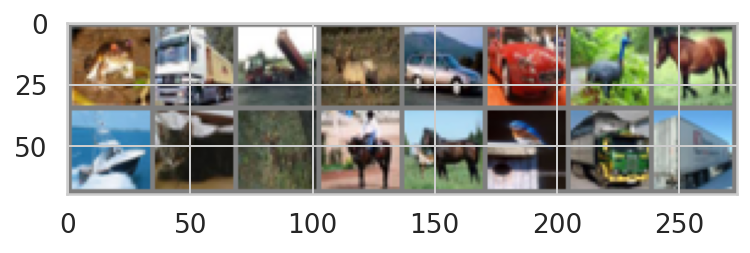


 frog truck truck  deer   car   car  bird horse  ship   cat  deer horse horse  bird truck truck


In [16]:
# get some random training images
dataiter = iter(loader_train)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

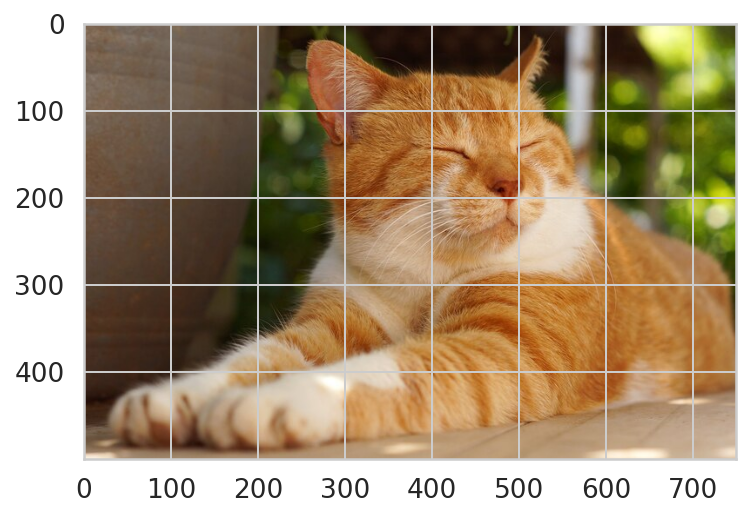

torch.Size([3, 500, 750])
torch.Size([1, 3, 500, 750])


In [17]:
# read and visualize an image
img = cv.imread("./cat.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

img = np.array(img)
# apply the transforms
img = transform(img)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())

#### 2 - Train/Test helper functions

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = defaultdict(list)
    model = model.to(device)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train' :
                train_acc = epoch_acc
                train_loss = epoch_loss 
            else :
                val_acc = epoch_acc 
                val_loss = epoch_loss 

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'best_model_state.bin')

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    model = model.to(device)
    return model,history

In [19]:
def eval_model(model, data_loader, loss_fn):
    model = model.eval()

    losses = []
    correct_predictions = 0
    model = model.to(device)
    loss_fn = loss_fn.to(device)

    with torch.no_grad():
        for d in data_loader:

            # Preparing inputs
            images, targets = d
            targets = targets.to(device)
            images = images.to(device)
            

            # Running inference using the model

            outputs = model(images)
            
            # Running softmax on the outputs
            _, preds = torch.max(outputs.data, dim=1)

            # Computing loss function
            loss = loss_fn(outputs, targets)

            # Counting the correct occurences
            correct_predictions += torch.sum(preds == targets)

            # Computing the precision (true positives/true positives + false positives) 
            # for each class and label, and find their average weighted by support 

            losses.append(loss.item())

    return correct_predictions.double() / 10000, np.mean(losses)

In [20]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  predictions = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      
      # Preparing inputs
      images, targets = d
      targets = targets.to(device)
      images = images.to(device)

      outputs = model(images)
      _, preds = torch.max(outputs.data, dim=1)

      probs = F.softmax(outputs, dim=1)

      predictions.extend(preds)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return  predictions, real_values

In [21]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True labels')
  plt.xlabel('Predicted labels');

### II - Pretrained model : Resnet

#### 1 - Finetune all layers

In [22]:
res_mod = models.resnet34(pretrained=True)

In [23]:
print(res_mod)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
num_ftrs = res_mod.fc.in_features
res_mod.fc = nn.Linear(num_ftrs, len(classes))

In [25]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(res_mod.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [26]:
base_model,history = train_model(res_mod, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
Iterating through data...
train Loss: 1.1259 Acc: 0.6096
Iterating through data...
val Loss: 0.7403 Acc: 0.7510

Epoch 1/14
----------
Iterating through data...
train Loss: 0.8077 Acc: 0.7231
Iterating through data...
val Loss: 0.6918 Acc: 0.7770

Epoch 2/14
----------
Iterating through data...
train Loss: 0.7745 Acc: 0.7335
Iterating through data...
val Loss: 0.7464 Acc: 0.7550

Epoch 3/14
----------
Iterating through data...
train Loss: 0.6409 Acc: 0.7783
Iterating through data...
val Loss: 0.6464 Acc: 0.7910

Epoch 4/14
----------
Iterating through data...
train Loss: 0.4642 Acc: 0.8405
Iterating through data...
val Loss: 0.7774 Acc: 0.7780

Epoch 5/14
----------
Iterating through data...
train Loss: 0.3561 Acc: 0.8762
Iterating through data...
val Loss: 0.6935 Acc: 0.8040

Epoch 6/14
----------
Iterating through data...
train Loss: 0.1812 Acc: 0.9407
Iterating through data...
val Loss: 0.6593 Acc: 0.8270

Epoch 7/14
----------
Iterating through data...
train L

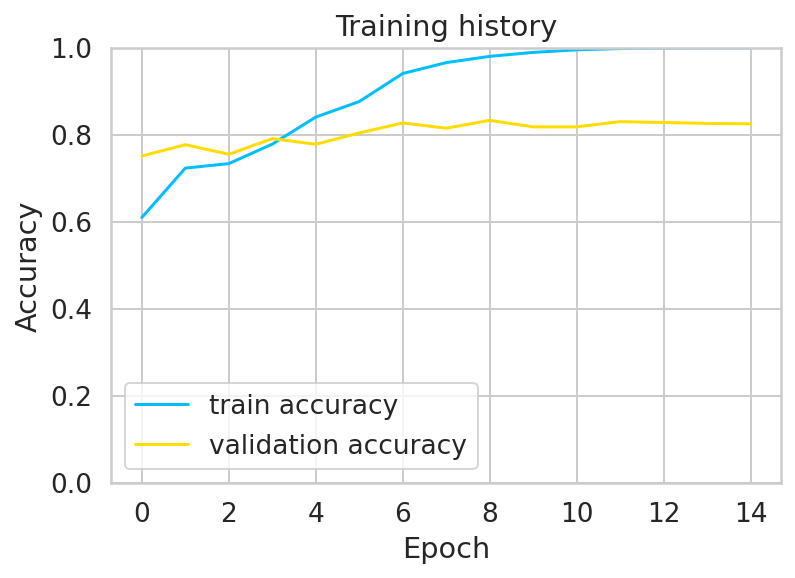

In [27]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

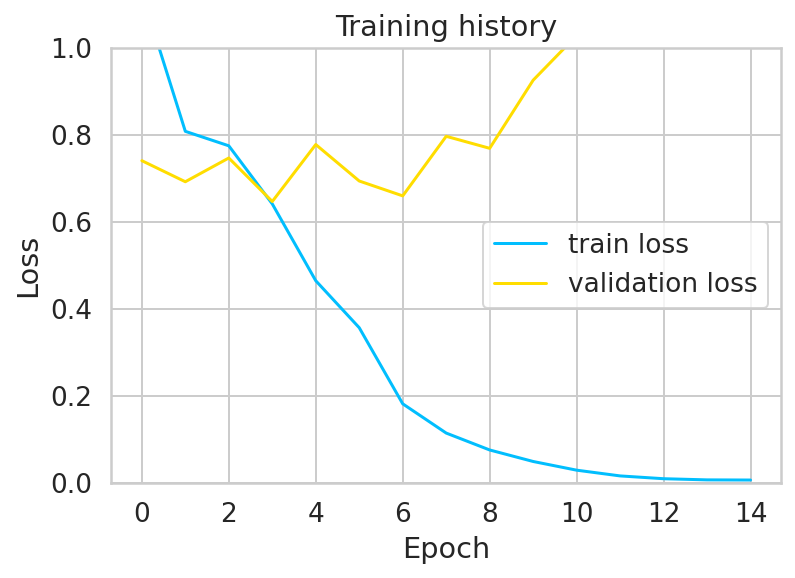

In [28]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [29]:
test_acc, _ = eval_model(base_model,loader_test,criterion)

#test_acc.item()
print('Accuracy on the test set is %.2f %%' %test_acc.item() )

Accuracy on the test set is 0.82 %


In [30]:
y_pred, y_test = get_predictions(
  base_model,
  loader_test
)

In [31]:
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

       plane       0.81      0.85      0.83      1000
         car       0.91      0.89      0.90      1000
        bird       0.78      0.77      0.77      1000
         cat       0.70      0.65      0.67      1000
        deer       0.76      0.79      0.77      1000
         dog       0.75      0.72      0.73      1000
        frog       0.87      0.87      0.87      1000
       horse       0.83      0.86      0.85      1000
        ship       0.89      0.89      0.89      1000
       truck       0.87      0.89      0.88      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



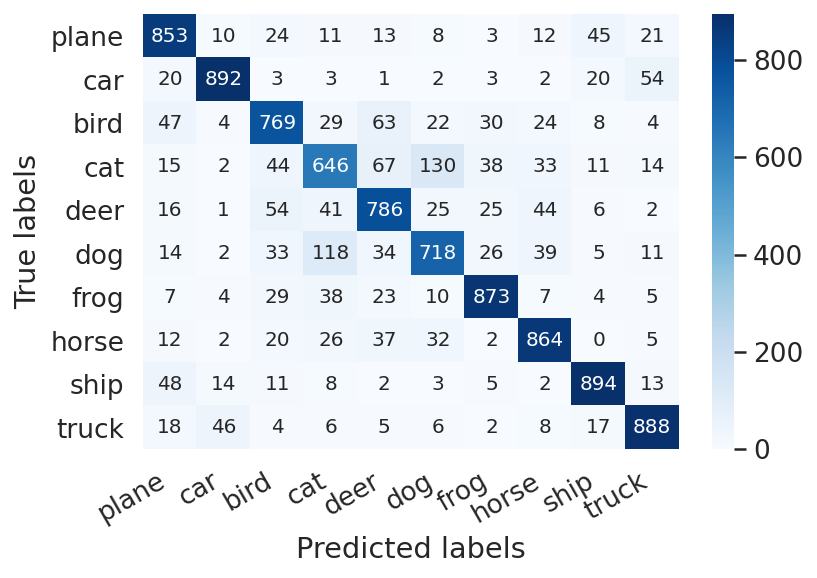

In [32]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
show_confusion_matrix(df_cm)

In [33]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(base_model.children())

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 33


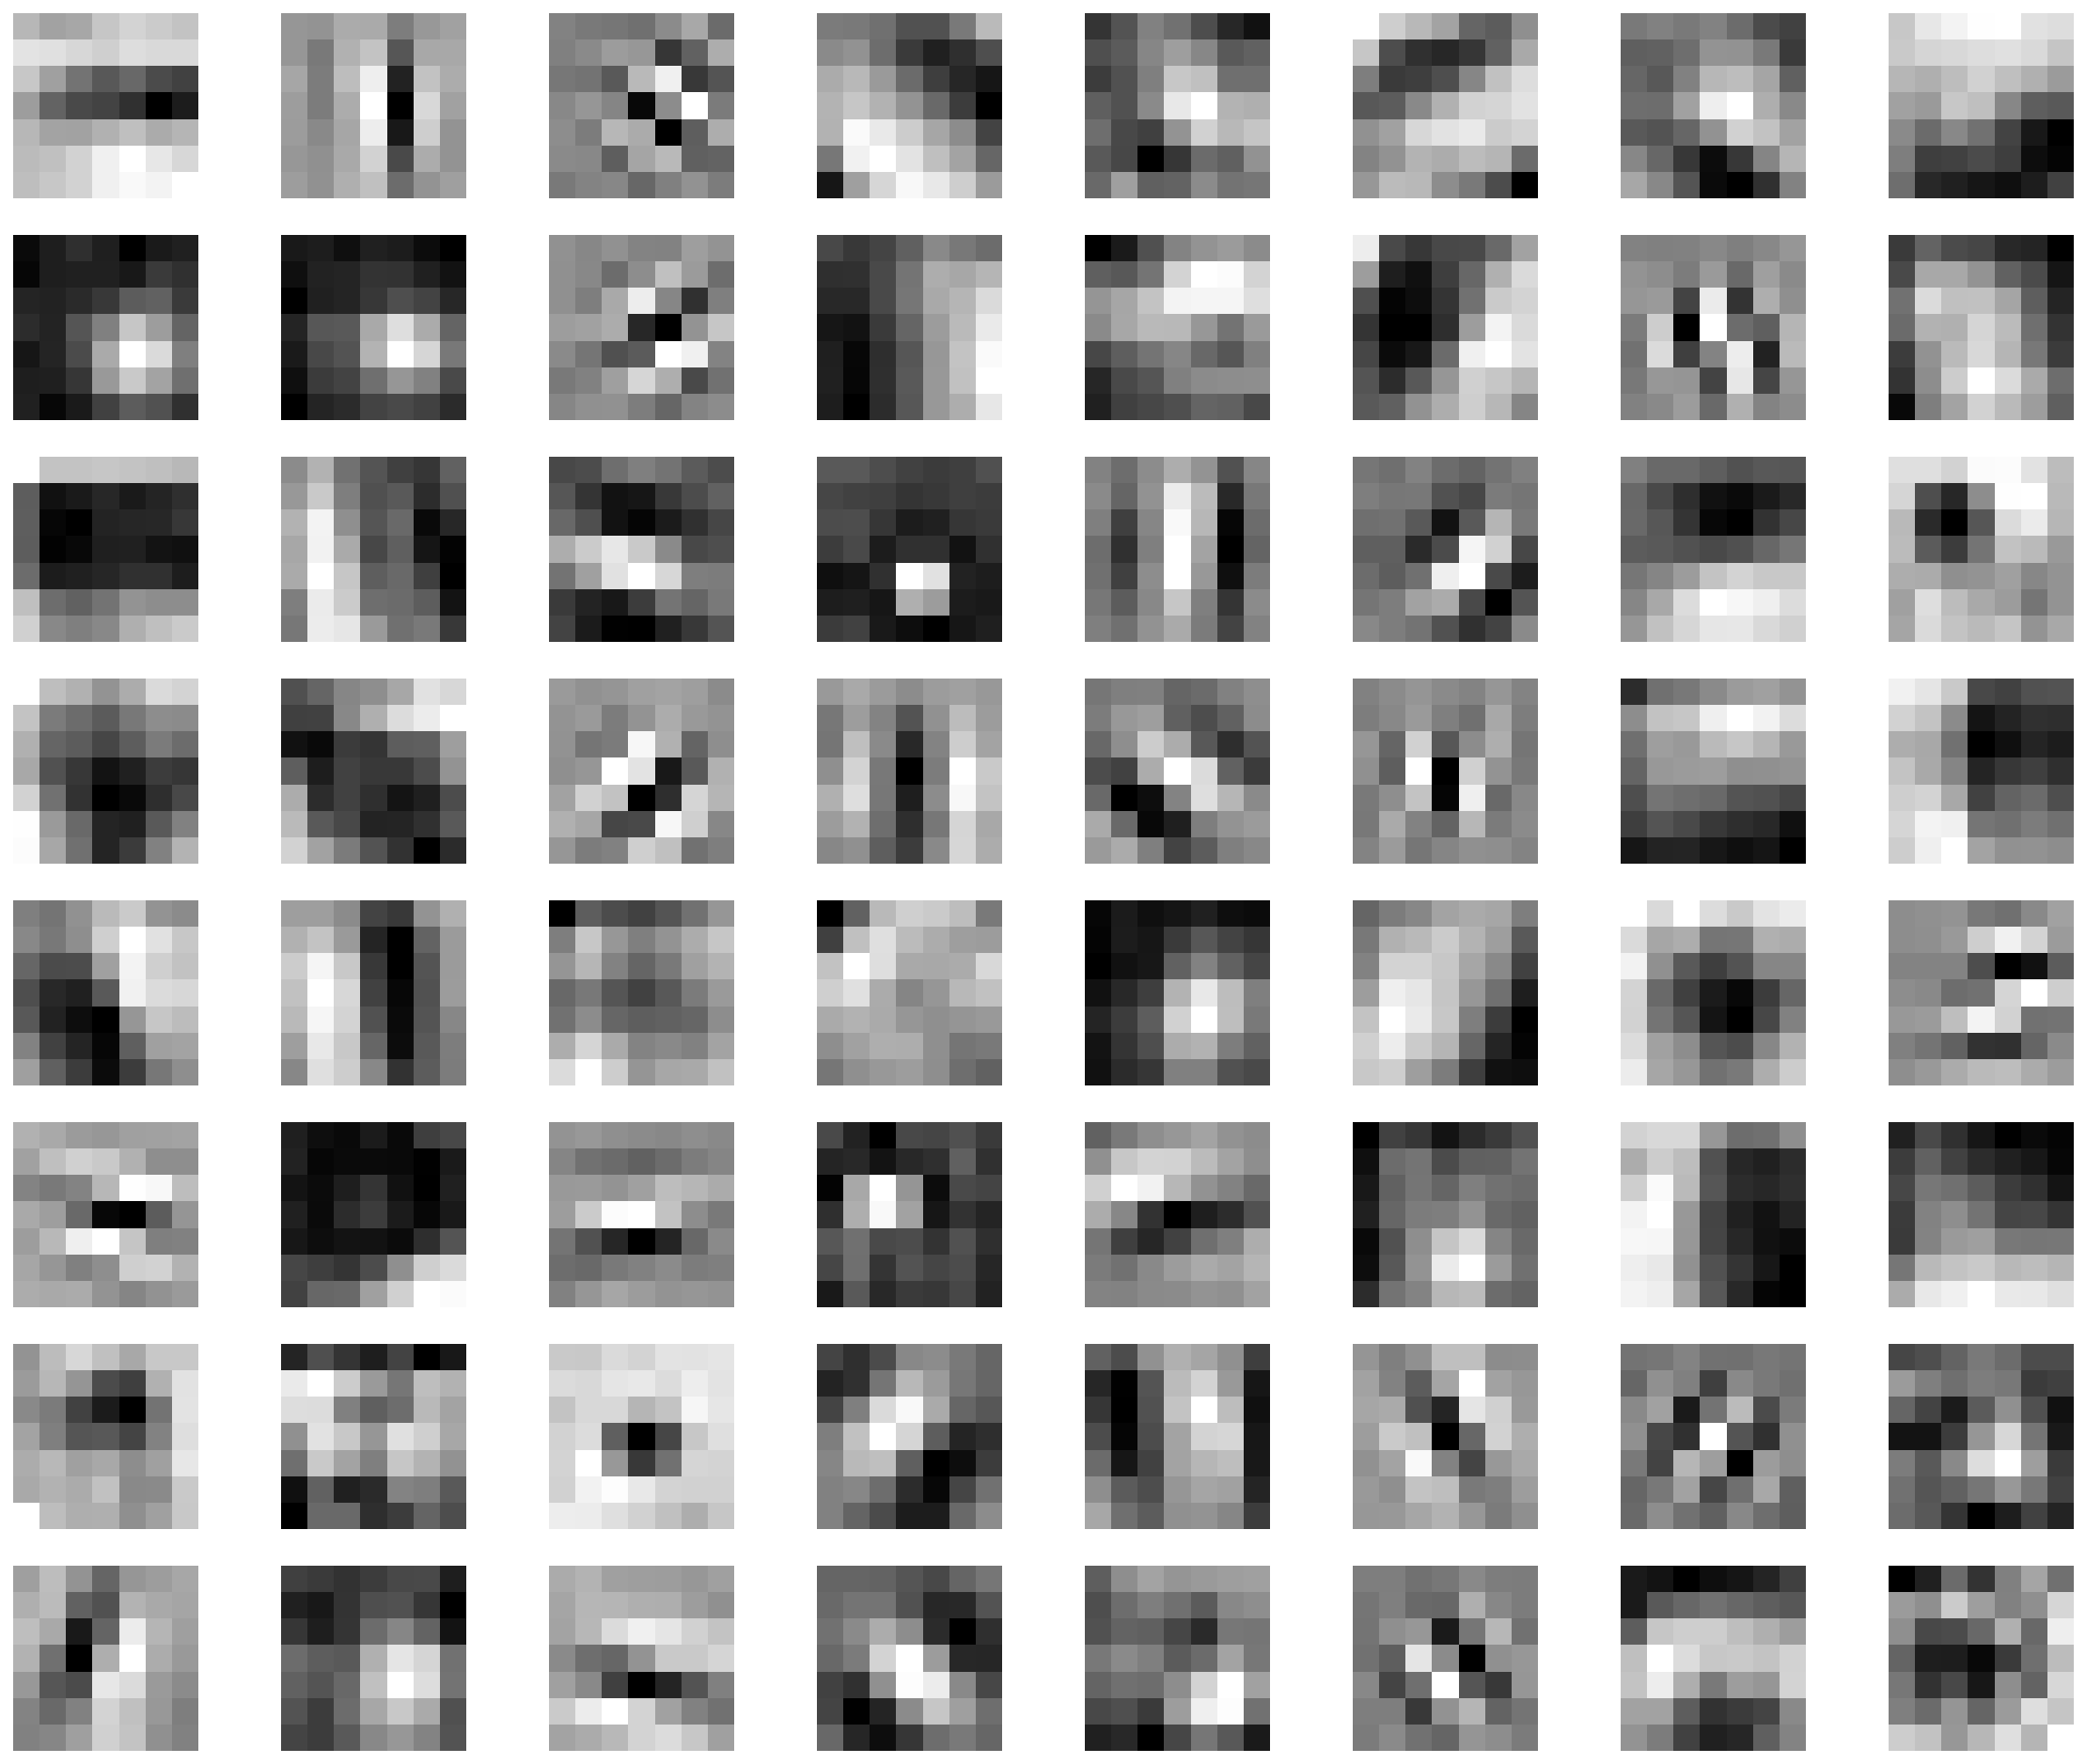

In [34]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    filter = filter.cpu()
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()

torch.Size([64, 250, 375])


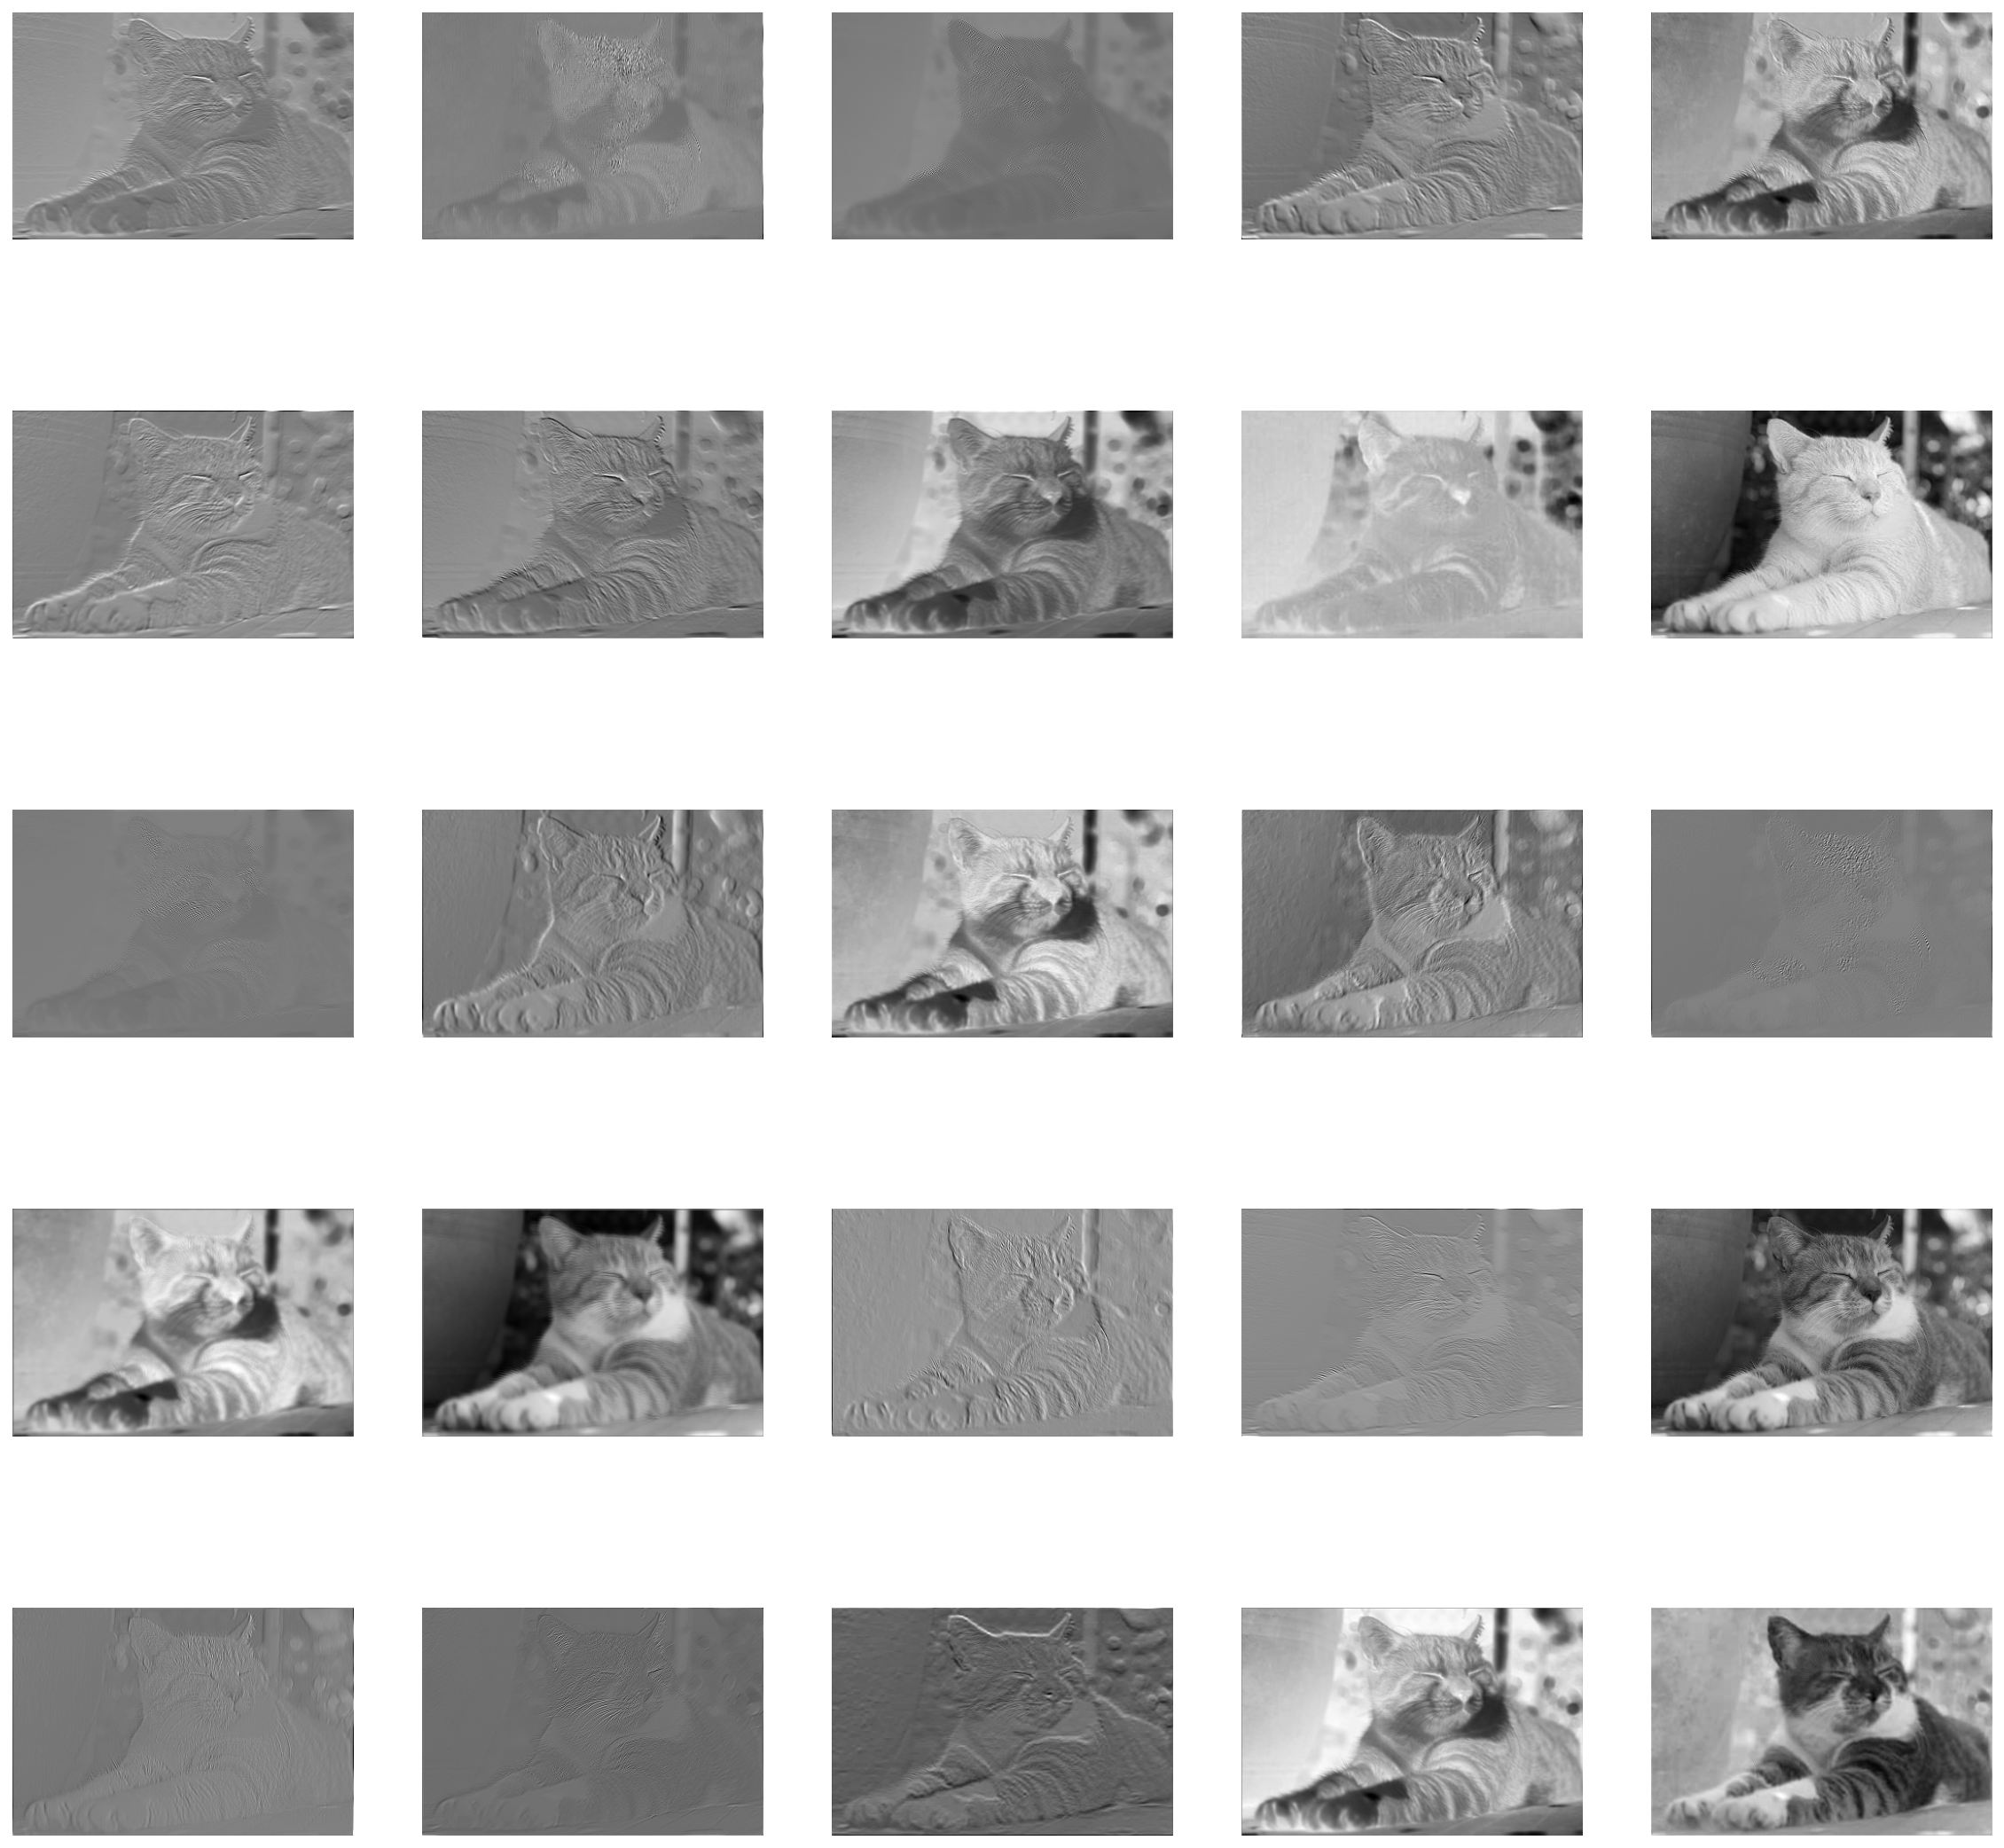

In [35]:
# pass the image through all the layers
img = img.to(device)
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(20, 20))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 25: # we will visualize only 5x5 blocks from each layer
            break
        plt.subplot(5, 5, i + 1)
        filter = filter.cpu()
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()
    # Showing first layer only for now
    break

#### 2 - Finetune two last layers

In [29]:
frozen_res_mod = models.resnet34(pretrained=True)
for param in frozen_res_mod.parameters():
    param.requires_grad = False

num_ftrs = frozen_res_mod.fc.in_features
frozen_res_mod.fc = nn.Linear(num_ftrs, len(classes))

In [30]:
for name, child in frozen_res_mod.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [31]:
for name, child in frozen_res_mod.named_children():
    if name in ['layer4','fc']:
        print(name + 'has been unfrozen.')
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

layer4has been unfrozen.
fchas been unfrozen.


In [32]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(filter(lambda x: x.requires_grad, frozen_res_mod.parameters()), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [33]:
base_model,history = train_model(frozen_res_mod, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
Iterating through data...
train Loss: 1.3869 Acc: 0.5155
Iterating through data...
val Loss: 1.1596 Acc: 0.6280

Epoch 1/14
----------
Iterating through data...
train Loss: 0.9791 Acc: 0.6590
Iterating through data...
val Loss: 1.1665 Acc: 0.6480

Epoch 2/14
----------
Iterating through data...
train Loss: 0.7054 Acc: 0.7539
Iterating through data...
val Loss: 1.2581 Acc: 0.6360

Epoch 3/14
----------
Iterating through data...
train Loss: 0.5253 Acc: 0.8156
Iterating through data...
val Loss: 1.4667 Acc: 0.6260

Epoch 4/14
----------
Iterating through data...
train Loss: 0.4179 Acc: 0.8514
Iterating through data...
val Loss: 1.5615 Acc: 0.6230

Epoch 5/14
----------
Iterating through data...
train Loss: 0.3064 Acc: 0.8911
Iterating through data...
val Loss: 1.8024 Acc: 0.6230

Epoch 6/14
----------
Iterating through data...
train Loss: 0.1616 Acc: 0.9458
Iterating through data...
val Loss: 1.8238 Acc: 0.6400

Epoch 7/14
----------
Iterating through data...
train L

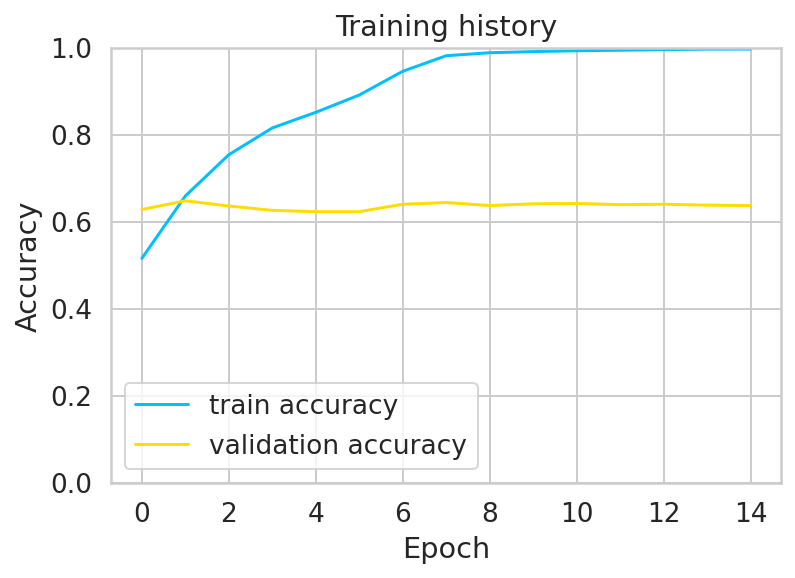

In [37]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

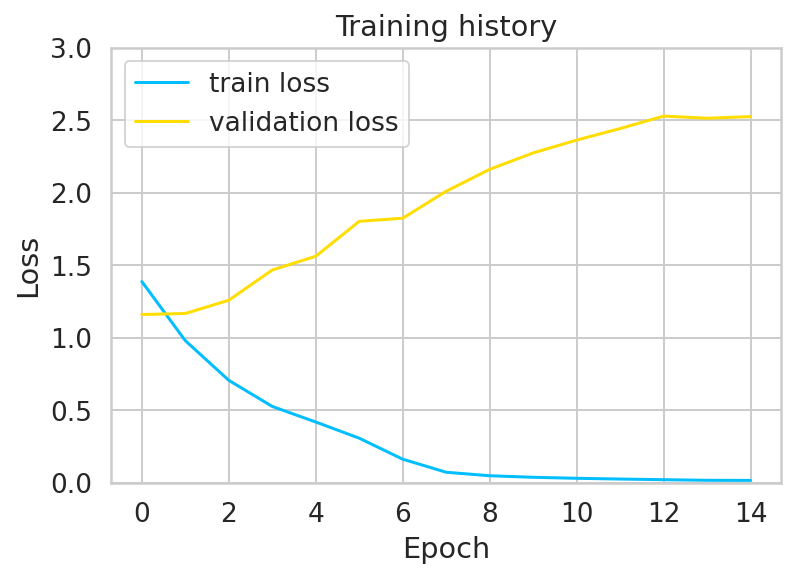

In [38]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 3]);

In [39]:
test_acc, _ = eval_model(base_model,loader_test,criterion)
print('Accuracy on the test set is %.2f %%' %test_acc.item() )

Accuracy on the test set is 0.62 %


In [40]:
y_pred, y_test = get_predictions(
  base_model,
  loader_test
)

In [41]:
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

       plane       0.66      0.63      0.64      1000
         car       0.72      0.69      0.71      1000
        bird       0.52      0.50      0.51      1000
         cat       0.43      0.60      0.50      1000
        deer       0.54      0.61      0.57      1000
         dog       0.63      0.47      0.54      1000
        frog       0.66      0.72      0.69      1000
       horse       0.67      0.69      0.68      1000
        ship       0.75      0.67      0.71      1000
       truck       0.76      0.63      0.69      1000

    accuracy                           0.62     10000
   macro avg       0.63      0.62      0.62     10000
weighted avg       0.63      0.62      0.62     10000



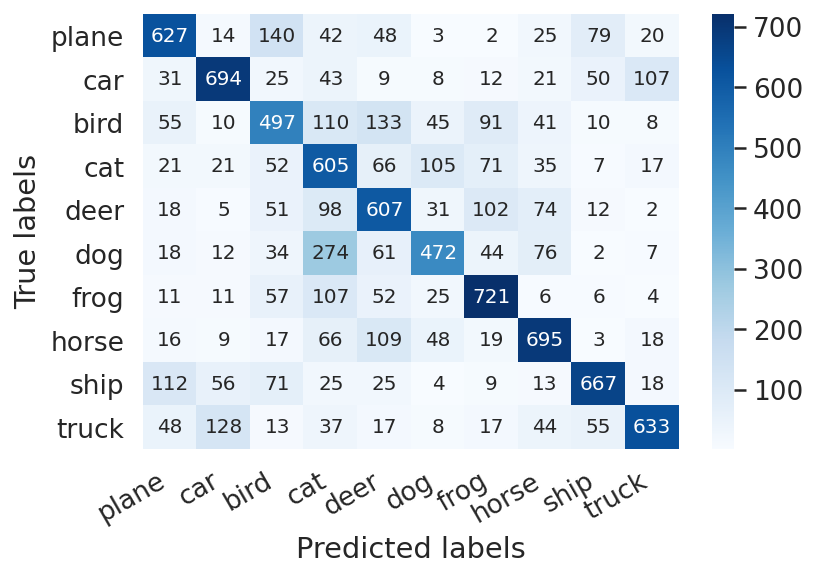

In [42]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
show_confusion_matrix(df_cm)

#### 3 - Finetune only last layer

In [ ]:
frozen_res_mod = models.resnet34(pretrained=True)
for param in frozen_res_mod.parameters():
    param.requires_grad = False

num_ftrs = frozen_res_mod.fc.in_features
frozen_res_mod.fc = nn.Linear(num_ftrs, len(classes))

for name, child in frozen_res_mod.named_children():
    if name in ['fc']:
        print(name + 'has been unfrozen.')
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False


criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(filter(lambda x: x.requires_grad, frozen_res_mod.parameters()), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
base_model,history = train_model(frozen_res_mod, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

In [ ]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 3]);

In [ ]:
test_acc, _ = eval_model(base_model,loader_test,criterion)
print('Accuracy on the test set is %.2f %%' %test_acc.item() )

In [ ]:
y_pred, y_test = get_predictions(
  base_model,
  loader_test
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=classes))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
show_confusion_matrix(df_cm)

### III - Existing architecture : Squeezenet

In [123]:
squeeze = torchvision.models.squeezenet1_0(pretrained=False)

In [124]:
print(squeeze)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

#### 1 - Finetuning the classification layer

In [ ]:
squeeze = torchvision.models.squeezenet1_0(pretrained=True)

In [ ]:
squeeze.classifier._modules["1"] = nn.Conv2d(512, len(classes), kernel_size=(1, 1))

In [ ]:
squeeze.num_classes = len(classes)

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(squeeze.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
base_model,history = train_model(squeeze, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

In [ ]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 3]);

In [ ]:
test_acc, _ = eval_model(base_model,loader_test,criterion)
print('Accuracy on the test set is %.2f %%' %test_acc.item() )

In [ ]:
y_pred, y_test = get_predictions(
  base_model,
  loader_test
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=classes))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
show_confusion_matrix(df_cm)

#### 2 - Training the model from scratch

In [124]:
squeeze = torchvision.models.squeezenet1_0(pretrained=False)

In [125]:
squeeze.classifier._modules["1"] = nn.Conv2d(512, len(classes), kernel_size=(1, 1))

In [126]:
squeeze.num_classes = len(classes)

In [127]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(squeeze.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [128]:
base_model,history = train_model(squeeze, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
Iterating through data...
train Loss: 2.0296 Acc: 0.2317
Iterating through data...
val Loss: 1.7603 Acc: 0.3590

Epoch 1/14
----------
Iterating through data...
train Loss: 1.6242 Acc: 0.3863
Iterating through data...
val Loss: 1.5822 Acc: 0.4300

Epoch 2/14
----------
Iterating through data...
train Loss: 1.4935 Acc: 0.4490
Iterating through data...
val Loss: 1.4510 Acc: 0.4730

Epoch 3/14
----------
Iterating through data...
train Loss: 1.4012 Acc: 0.4888
Iterating through data...
val Loss: 1.3666 Acc: 0.5110

Epoch 4/14
----------
Iterating through data...
train Loss: 1.3333 Acc: 0.5193
Iterating through data...
val Loss: 1.4065 Acc: 0.4990

Epoch 5/14
----------
Iterating through data...
train Loss: 1.2673 Acc: 0.5462
Iterating through data...
val Loss: 1.2796 Acc: 0.5400

Epoch 6/14
----------
Iterating through data...
train Loss: 1.1057 Acc: 0.6020
Iterating through data...
val Loss: 1.1336 Acc: 0.5790

Epoch 7/14
----------
Iterating through data...
train L

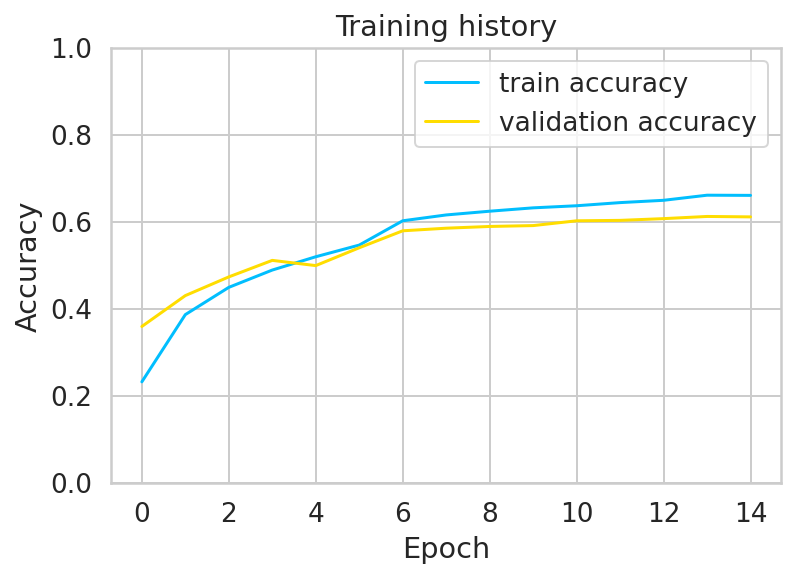

In [129]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

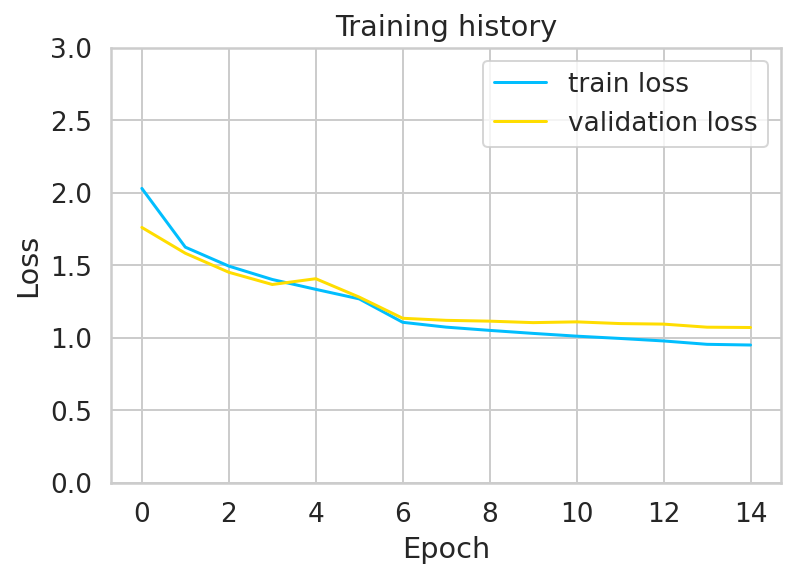

In [130]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 3]);

In [131]:
test_acc, _ = eval_model(base_model,loader_test,criterion)
print('Accuracy on the test set is %.2f %%' %test_acc.item() )

Accuracy on the test set is 0.61 %


In [132]:
y_pred, y_test = get_predictions(
  base_model,
  loader_test
)

In [133]:
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

       plane       0.65      0.67      0.66      1000
         car       0.74      0.72      0.73      1000
        bird       0.47      0.46      0.47      1000
         cat       0.42      0.39      0.40      1000
        deer       0.55      0.54      0.54      1000
         dog       0.54      0.51      0.52      1000
        frog       0.63      0.74      0.68      1000
       horse       0.70      0.65      0.67      1000
        ship       0.73      0.76      0.74      1000
       truck       0.68      0.68      0.68      1000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000



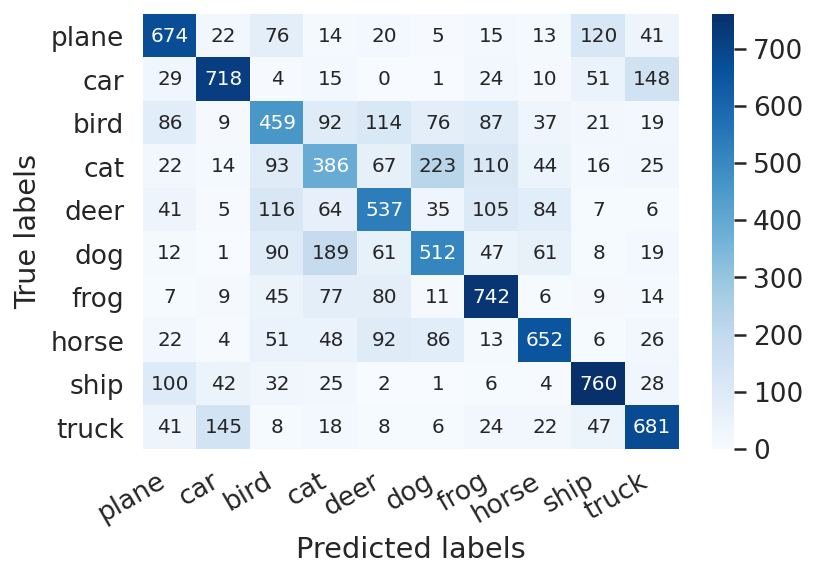

In [134]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
show_confusion_matrix(df_cm)

### IV - CNN Model trained from scratch

In [63]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.fc1 = nn.Linear(in_features=20 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.drop = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(in_features=84, out_features=len(classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20 * 5 * 5) #flattening
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [64]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [65]:
base_model,history = train_model(net, criterion, optimizer, exp_lr_scheduler, num_epochs=30)

Epoch 0/49
----------
Iterating through data...
train Loss: 1.6125 Acc: 0.4088
Iterating through data...
val Loss: 1.4005 Acc: 0.4950

Epoch 1/49
----------
Iterating through data...
train Loss: 1.2904 Acc: 0.5431
Iterating through data...
val Loss: 1.2747 Acc: 0.5450

Epoch 2/49
----------
Iterating through data...
train Loss: 1.1913 Acc: 0.5806
Iterating through data...
val Loss: 1.1821 Acc: 0.5890

Epoch 3/49
----------
Iterating through data...
train Loss: 1.1264 Acc: 0.6081
Iterating through data...
val Loss: 1.2001 Acc: 0.5980

Epoch 4/49
----------
Iterating through data...
train Loss: 1.0942 Acc: 0.6200
Iterating through data...
val Loss: 1.2604 Acc: 0.5840

Epoch 5/49
----------
Iterating through data...
train Loss: 1.0672 Acc: 0.6322
Iterating through data...
val Loss: 1.2310 Acc: 0.5900

Epoch 6/49
----------
Iterating through data...
train Loss: 0.8045 Acc: 0.7165
Iterating through data...
val Loss: 1.0629 Acc: 0.6590

Epoch 7/49
----------
Iterating through data...
train L

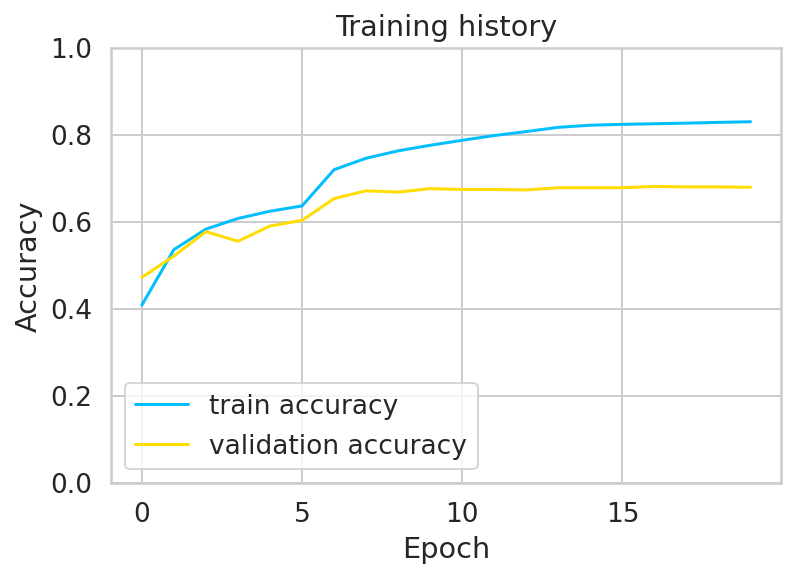

In [56]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 3]);

In [48]:
test_acc, _ = eval_model(base_model,loader_test,criterion)
print('Accuracy on the test set is %.2f %%' %test_acc.item() )

Accuracy on the test set is 0.68 %


In [49]:
y_pred, y_test = get_predictions(
  base_model,
  loader_test
)

In [50]:
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

       plane       0.71      0.73      0.72      1000
         car       0.82      0.80      0.81      1000
        bird       0.58      0.56      0.57      1000
         cat       0.44      0.47      0.45      1000
        deer       0.63      0.60      0.61      1000
         dog       0.56      0.53      0.54      1000
        frog       0.74      0.80      0.77      1000
       horse       0.73      0.71      0.72      1000
        ship       0.80      0.79      0.79      1000
       truck       0.75      0.78      0.76      1000

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.67     10000
weighted avg       0.68      0.68      0.67     10000



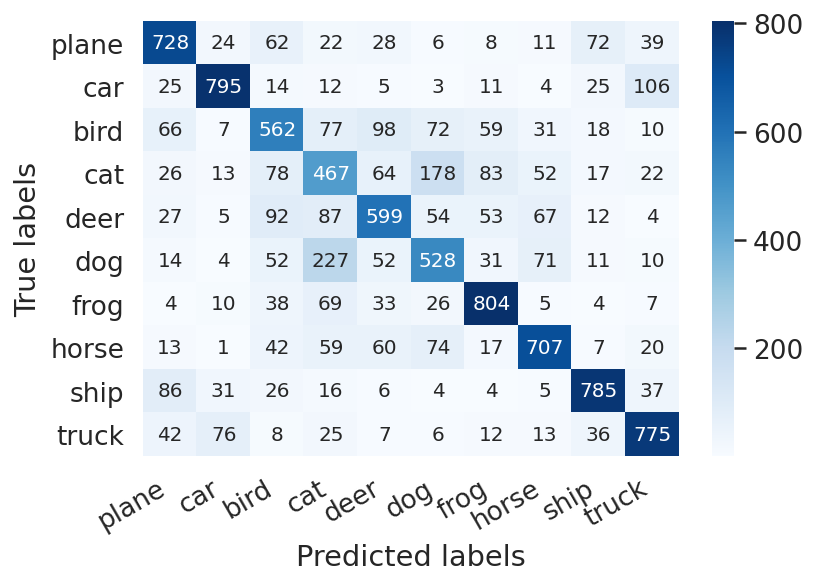

In [51]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
show_confusion_matrix(df_cm)

In [ ]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(base_model.children())

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

In [ ]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    filter = filter.cpu()
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
# pass the image through all the layers
img = img.to(device)
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(20, 20))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 25: # we will visualize only 5x5 blocks from each layer
            break
        plt.subplot(5, 5, i + 1)
        filter = filter.cpu()
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()
    # Showing first layer only for now
    break